In [32]:
# library imports

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# file imports
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [33]:
# taking a look at the data

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [34]:
# data cleanup functions

def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train = process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [35]:
# cleaning up the dataframes

def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, 'Age_categories')
    df = create_dummies(df, 'Fare_categories')
    df = create_dummies(df, 'Title')
    df = create_dummies(df, 'Cabin_type')
    df = create_dummies(df, 'Sex')
    return df

train = process_df(train)
holdout = process_df(holdout)

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,0,0,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,0,0,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,0,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,0,0,0,0,0,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,0,0,0,0,0,0,0,1,1,0


In [36]:
# Exploring the data
# data types
train.dtypes

PassengerId                      int64
Survived                         int64
Pclass                           int64
Name                            object
Sex                             object
Age                            float64
SibSp                            int64
Parch                            int64
Ticket                          object
Fare                           float64
Embarked                        object
Age_categories                category
Fare_categories               category
Title                           object
Cabin_type                      object
Age_categories_Missing           uint8
Age_categories_Infant            uint8
Age_categories_Child             uint8
Age_categories_Teenager          uint8
Age_categories_Young Adult       uint8
Age_categories_Adult             uint8
Age_categories_Senior            uint8
Fare_categories_0-12             uint8
Fare_categories_12-50            uint8
Fare_categories_50-100           uint8
Fare_categories_100+     

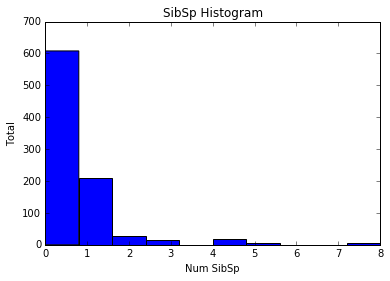

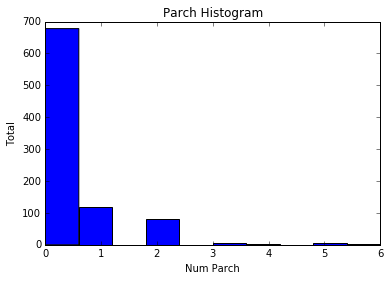

In [37]:
# histograms

train_hist_SibSp = plt.hist(train['SibSp'])
plt.title('SibSp Histogram')
plt.xlabel('Num SibSp')
plt.ylabel('Total')
plt.show()

train_hist_Parch = plt.hist(train['Parch'])
plt.title('Parch Histogram')
plt.xlabel('Num Parch')
plt.ylabel('Total')
plt.show()

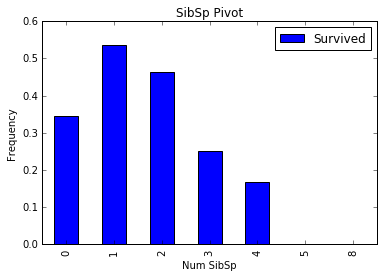

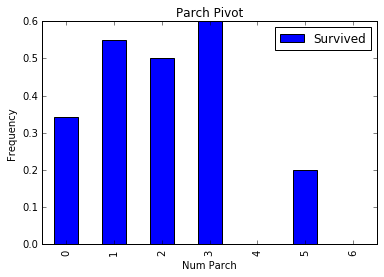

In [38]:
# pivot tables

train_pivot_SibSp = train.pivot_table(index='SibSp', values='Survived')
train_pivot_SibSp.plot.bar()
plt.title('SibSp Pivot')
plt.xlabel('Num SibSp')
plt.ylabel('Frequency')
plt.show()

train_pivot_Parch = train.pivot_table(index='Parch', values='Survived')
train_pivot_Parch.plot.bar()
plt.title('Parch Pivot')
plt.xlabel('Num Parch')
plt.ylabel('Frequency')
plt.show()

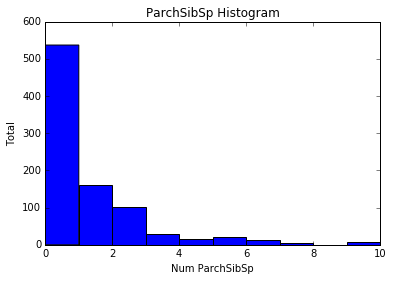

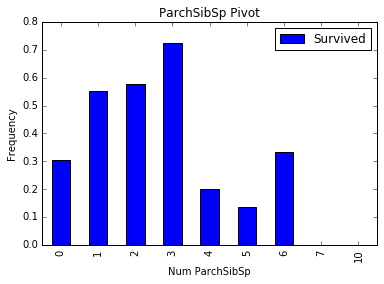

In [39]:
"""
Engineering a new field. Family size

SibSp - The number of siblings or spouses the passenger had aboard the Titanic
Parch - The number of parents or children the passenger had aboard the Titanic
"""

train['ParchSibSp'] = train['Parch'] + train['SibSp']
holdout['ParchSibSp'] = holdout['Parch'] + holdout['SibSp']

train_hist_ParchSibSp = plt.hist(train['ParchSibSp'])
plt.title('ParchSibSp Histogram')
plt.xlabel('Num ParchSibSp')
plt.ylabel('Total')
plt.show()

train_pivot_ParchSibSp = train.pivot_table(index='ParchSibSp', values='Survived')
train_pivot_ParchSibSp.plot.bar()
plt.title('ParchSibSp Pivot')
plt.xlabel('Num ParchSibSp')
plt.ylabel('Frequency')
plt.show()

# Summary
## Feature Preparation and Engineering
Train and holdout data sets were engineered as follows. 
1. Missing values for Fare and Embarked were filled in with the mean and na, respectively. 
2. Ages were bucketed into six (6) categories: Missing, Infant, Child, Teenager, Young Adult, Adult, and Senior. 
3. Fares were bucketed into four (4) categories: 0-12, 12-50, 50-100, and 100.
4. Cabin Type null values were replaced with 'Unknown'. 
5. Titles were extracted from the name column and categorized as: Mr, Mrs, Master, Miss, Officer, and Royalty. 
6. Dummy columns were created for the following fields: Age_categories, Fare_categories, Title, Cabin_type, and Sex. 
7. SibSp and Parch columns were summed to obtain a new column describing total number of siblings, spouses, parents, and children per passenger. 

## Data Exploration
### SibSp
Integer values with a geometric data distribution. Approximately 600 passengers had no siblings or spouses aboard. About 200 had one (1) sibling or spouse aboard. About 75 had two or more siblings or spouses aboard.

SibSp likely correlated with survival rates. Poisson distribution of data. If no siblings or spouses aboard, survival rate was about 35%. If one (1) or two (2) siblings or spouses were aboard, survival rate increased to 55% and 45%, respectively. If three (3) or more siblings or spouses were aboard, survival rates dropped below 25%.

### Parch
Integer values with a geometric data distribution. Approximately 675 passengers had no parents or children aboard. About 100 had one (1) parent or child aboard. About 75 had two or more siblings or spouses aboard. About 100 had two (2) parents and/or children aboard. Less than 50 had three (3) or more parents or children aboard.

Parch likely correlated with survival rates. If no parents or children were aboard, survival rate was about 35%. If one (1) to three (3) parents or children were aboard, survival rate increased to 55 - 60%. If four (4) or more parents or children were aboard, survival rates dropped below 20%.

### ParchSibSp
Integer values with a geometric data distribution. Approximately 550 passengers had no siblings, spouses, parents, or children aboard. About 150 had one (1) sibling, spouse, parent, or child aboard. About 100 had two (2) siblings, spouses, parents, or children aboard. About 100 had three (3) or more siblings, spouses, parents, or children aboard.

ParchSibSp likely correlated with survival rates. If no parents, children, siblings, or spouses were aboard, survival rate was about 30%. If one (1) to three (3) family memebers were aboard, survival rate increased to 55% to 70%. If four (4) or more family members were aboard, survival rates ranged between 15 -30%.

In [40]:
# function to identify those passengers that are alone

def process_ParchSipSp(df):
    """Process the ParchSipSp column into pre-defined 'bins' 

    Usage
    ------

    train = process_ParchSipSp(train)
    """
    cut_points = [-1, 0, 100]
    label_names = [0, 1]
    df["isalone"] = pd.cut(df["ParchSibSp"],cut_points,labels=label_names)
    return df

train = process_ParchSipSp(train)
holdout = process_ParchSipSp(holdout)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,ParchSibSp,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,1,0,1,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,1,0,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,1,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,1,0,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,1,0,1,0,0


In [41]:
def select_features(df):
    df = df.select_dtypes([np.number])
    all_X = df.drop(['Survived','PassengerId'],axis=1)
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    
    print(optimized_columns)
    return optimized_columns
    
best_features = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'ParchSibSp'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [43]:
# picking the best algorithm

def select_model(df, feature_list):
    all_X = df.loc[:, feature_list]
    all_y = df['Survived']
    dict_list = [
    {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
    },
    {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
    },
    {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(random_state=1),
        "hyperparameters":
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
    }
    ]
    
    counter = 0
    
    for param in dict_list:
        print(param['name'])
        grid = GridSearchCV(param['estimator'], param_grid = param['hyperparameters'], cv = 10)
        grid.fit(all_X, all_y)
        best_params = grid.best_params_
        print(grid.best_params_)
        best_score = grid.best_score_
        print(grid.best_score_)
        
        dict_list[counter]['name'] = param['name']
        dict_list[counter]['estimator'] = param['estimator']
        dict_list[counter]['hyperparameters'] = best_params
        dict_list[counter]['score'] = best_score
        
        counter = counter + 1
        
    return dict_list
    print('Done')

models = select_model(train, best_features)

LogisticRegression
{'solver': 'newton-cg'}
0.8215488215488216
KNeighborsClassifier
{'n_neighbors': 19, 'algorithm': 'brute', 'weights': 'distance', 'p': 1}
0.77665544332211
RandomForestClassifier
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'min_samples_split': 2}
0.8462401795735129


In [44]:
# Best model parameters

dict_BestModel = max(models, key=lambda d: d['score'])
dict_BestModel

{'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
             verbose=0, warm_start=False),
 'hyperparameters': {'criterion': 'gini',
  'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 9},
 'name': 'RandomForestClassifier',
 'score': 0.8462401795735129}

In [45]:
# saving the Kaggle submission file

def save_submission_file(df, feature_list, dict_BestModel, output_csvFileName):
    all_X = df.loc[:, feature_list]
    all_y = df['Survived']
    
    dict_BestModel['estimator'].fit(all_X, all_y)
    holdout_predictions = dict_BestModel['estimator'].predict(holdout.loc[:, feature_list])

    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                     "Survived": holdout_predictions}
    submission = pd.DataFrame(submission_df)
    
    print(submission[:10])

    return submission.to_csv(output_csvFileName, index=False)

submission = save_submission_file(train, best_features, dict_BestModel, 'Titantic.csv')


   PassengerId  Survived
0          892         0
1          893         0
2          894         1
3          895         1
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
